In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [201]:
emp = pd.read_csv("attrition.csv")
emp = emp[emp.YearsAtCompany != 40]
emp = emp.drop(index=1111).reset_index(drop=True)
emp = emp.drop(index=748).reset_index(drop=True)
# 748,747, 746

In [202]:
emp[(emp["YearsAtCompany"] > 30) & (emp['Gender'] == 'Female')]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


In [203]:
print(emp.Gender.unique())
print(emp.Department.unique())
print(emp.JobLevel.unique())

['Female' 'Male']
['Sales' 'Research & Development' 'Human Resources']
[2 1 3 4 5]


In [204]:
def plot_lifelines(obs):
    for y, row in obs.iterrows():
        start = row['start']
        end = row['end']
        status = row['status']
        
        if status == 0:
            plt.hlines(y, start, end, color='C0')
        else:
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1')
            
    plt.xlabel('Time (weeks)')
    plt.ylabel('Index')
    plt.gca().invert_yaxis()

Text(0.5, 0, 'Duration (years)')

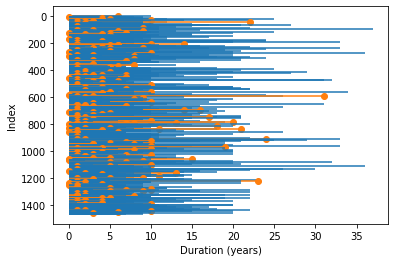

In [205]:
shifted = emp.copy()
shifted['start'] = 0
shifted['end'] = emp['YearsAtCompany']
shifted['status'] = emp['Attrition'].map({'Yes': 1, 'No': 0})

plot_lifelines(shifted)
plt.xlabel('Duration (years)')

In [206]:
ts = emp['YearsAtCompany'].unique()
ts.sort()
E, T = np.meshgrid(shifted['end'], ts)
at_risk = (T <= E).sum(axis=1)

#### Estimating hazard function

In [207]:
churned = pd.Series(0, index=ts)

for t in ts:
    k = (shifted['status'] == 1) & (t == shifted['end'])
    churned[t] = k.sum()

churn_times = np.where(shifted['status'], shifted['end'], np.nan)
A, T = np.meshgrid(churn_times, ts)
churned = (T == A).sum(axis=1)



In [208]:
d = dict(churned=churned, 
         at_risk=at_risk)
dfc = pd.DataFrame(d, index=ts)
dfc.head()

dfc['hazard'] = dfc['churned'] / dfc['at_risk']
dfc.head()

,churned,at_risk,hazard
0,16,1467,0.010907
1,59,1423,0.041462
2,27,1252,0.021565
3,20,1125,0.017778
4,19,997,0.019057


The hazard function is the probability of being churned at each duration, so its complement is the probability of not being churned.

In [209]:
dfc['surv'] = (1 - dfc['hazard']).cumprod()

The cumulative distribution function CDF is the complement of the survival function.

In [210]:
dfc['cdf'] = 1 - dfc['surv']

And the probability density function PMF is the difference between adjacent elements of the CDF.

In [211]:
dfc['pmf'] = np.diff(dfc['cdf'], prepend=0)
dfc.head()

,churned,at_risk,hazard,surv,cdf,pmf
0,16,1467,0.010907,0.989093,0.010907,0.010907
1,59,1423,0.041462,0.948084,0.051916,0.041009
2,27,1252,0.021565,0.927638,0.072362,0.020446
3,20,1125,0.017778,0.911147,0.088853,0.016491
4,19,997,0.019057,0.893783,0.106217,0.017364


#### Kaplan-Maier Curve Estimation (Non-Parametric)

In [212]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
T = shifted['end']
E = shifted['status']
kmf.fit(T, E)
kmf.survival_function_.head()

,KM_estimate
timeline,
0.0,0.989093
1.0,0.948084
2.0,0.927638
3.0,0.911147
4.0,0.893783


timelines includes an element at t=0, but other than that it is identical to what we computed (except for floating-point error).

In [213]:
max(abs(kmf.survival_function_['KM_estimate'] - dfc['surv']).dropna())

2.1094237467877974e-15

lifelines also computes a confidence interval for the survival function.

In [214]:
ci = kmf.confidence_interval_survival_function_

Text(0.5, 0, 'timeline (years)')

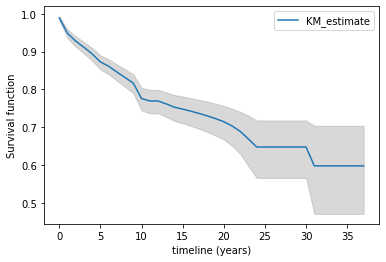

In [215]:
ts = ci.index
low, high = np.transpose(ci.values)

plt.fill_between(ts, low, high, color='gray', alpha=0.3)
kmf.survival_function_.plot(ax=plt.gca())
plt.ylabel('Survival Function')
plt.xlabel('timeline (years)')

Median Survival Time and Confidence Intervals

In [216]:
from lifelines.utils import median_survival_times
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

inf
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                    31.0                     inf


KM plots by category

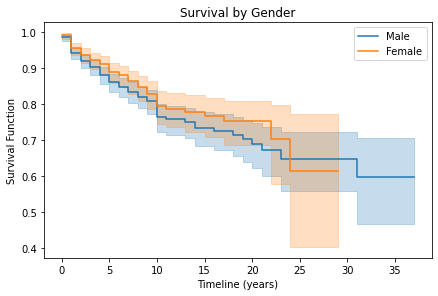

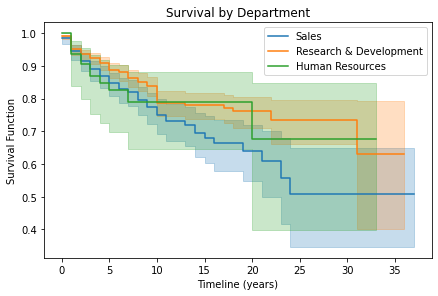

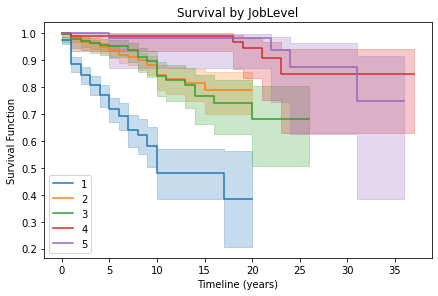

In [217]:
categories = [('Gender', ['Male', 'Female']),
              ('Department', ['Sales', 'Research & Development', 'Human Resources']),
              ('JobLevel', [1, 2, 3, 4, 5])]

for category, values in categories:
    fig, ax = plt.subplots()
    for value in values:
        mask = shifted[category] == value
        kmf.fit(T[mask], E[mask], label=value)
        kmf.plot_survival_function(ax=ax)
    plt.tight_layout()
    plt.xlabel('Timeline (years)')
    plt.ylabel('Survival Function')
    plt.title(f"Survival by {category}")


Cox Proportional Hazard Model (Semi-Parametric)

Assumptions
- Independence of survival times between distinct individuals in the sample
- A multiplicative relationship between the predictors and the hazard, and
- A constant hazard ratio over time.

Definition of Hazard and Hazard Ratio

- Hazard is defined as the slope of the survival curve. It is a measure of how rapidly subjects are churning.
- The hazard ratio compares two groups. If the hazard ratio is 2.0, then the rate of attrition in one group is twice the rate in the other group.

In [220]:
dum_depart = pd.get_dummies(shifted["Department"], prefix = 'Department')
dum_level = pd.get_dummies(shifted["JobLevel"], prefix = 'JobLevel')

dum = pd.concat([dum_depart, dum_level], axis = 1)
dum.head()

,Department_Human Resources,Department_Research & Development,Department_Sales,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5
0,0,0,1,0,1,0,0,0
1,0,1,0,0,1,0,0,0
2,0,1,0,1,0,0,0,0
3,0,1,0,1,0,0,0,0
4,0,1,0,1,0,0,0,0


In [223]:
ndf = pd.concat([shifted, dum], axis =1)
ndf = ndf.drop(['Department', 'JobLevel'], axis=1)
ndf.head()

In [224]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(ndf, duration_col = 'time', event_col = 'status')
cph.print_summary()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,end,status,Department_Human Resources,Department_Research & Development,Department_Sales,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5
0,41,Yes,Travel_Rarely,1102,1,2,Life Sciences,1,1,2,...,6,1,0,0,1,0,1,0,0,0
1,49,No,Travel_Frequently,279,8,1,Life Sciences,1,2,3,...,10,0,0,1,0,0,1,0,0,0
2,37,Yes,Travel_Rarely,1373,2,2,Other,1,4,4,...,0,1,0,1,0,1,0,0,0,0
3,33,No,Travel_Frequently,1392,3,4,Life Sciences,1,5,4,...,8,0,0,1,0,1,0,0,0,0
4,27,No,Travel_Rarely,591,2,1,Medical,1,7,1,...,2,0,0,1,0,1,0,0,0,0
